In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import roc_curve , roc_auc_score , accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score , recall_score , f1_score

# **Reading Data**

In [4]:
df = pd.read_csv("/content/diabetes.csv")

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# **Data Exploration**

In [8]:
df.shape

(768, 9)

In [9]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [10]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
435,0,141,0,0,0,42.4,0.205,29,1
622,6,183,94,0,0,40.8,1.461,45,0
531,0,107,76,0,0,45.3,0.686,24,0
292,2,128,78,37,182,43.3,1.224,31,1
676,9,156,86,0,0,24.8,0.230,53,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [12]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [13]:
df.duplicated().sum()

0

In [14]:
df.nunique()

,0
Pregnancies,17
Glucose,136
BloodPressure,47
SkinThickness,51
Insulin,186
BMI,248
DiabetesPedigreeFunction,517
Age,52
Outcome,2


In [15]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


# **Data Analysis & Processing**

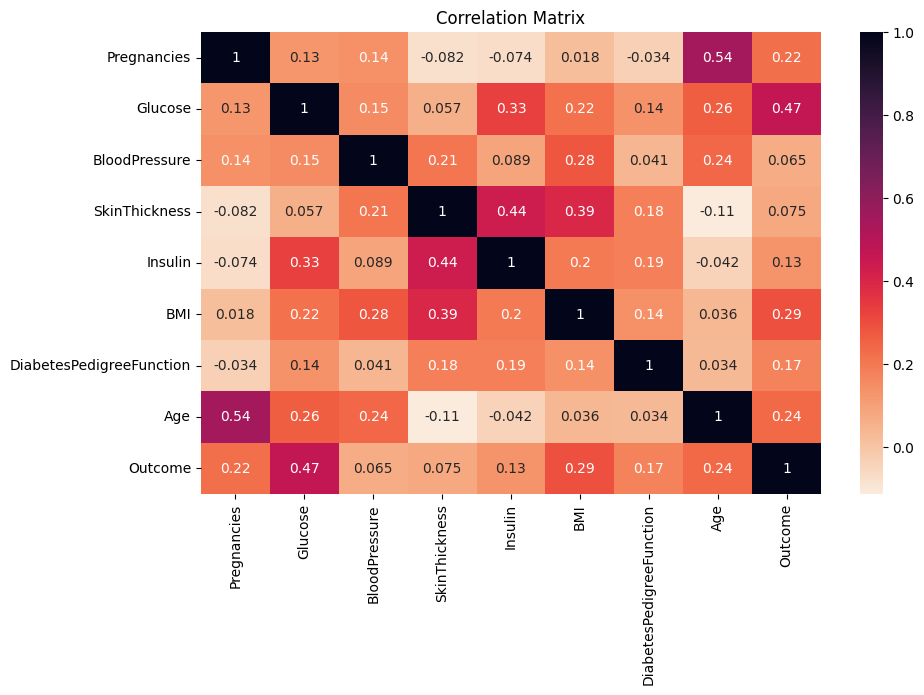

In [16]:
plt.figure(figsize=(10,6))
plt.title("Correlation Matrix" )
sns.heatmap(df.corr() , annot = True , cmap="rocket_r")
plt.show()

In [17]:
df['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


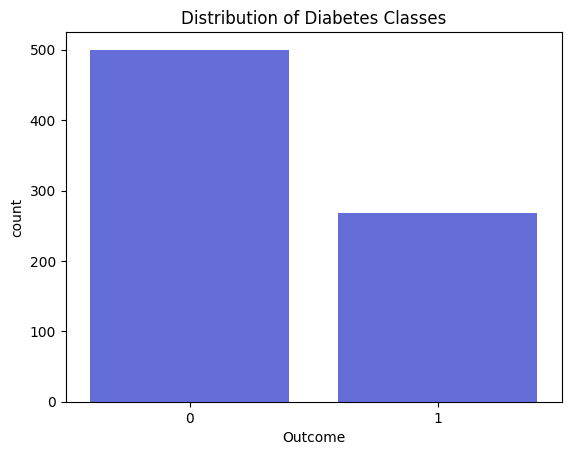

In [18]:
sns.countplot(data = df , x = 'Outcome', color = '#525CEB')
plt.title("Distribution of Diabetes Classes")
plt.show()

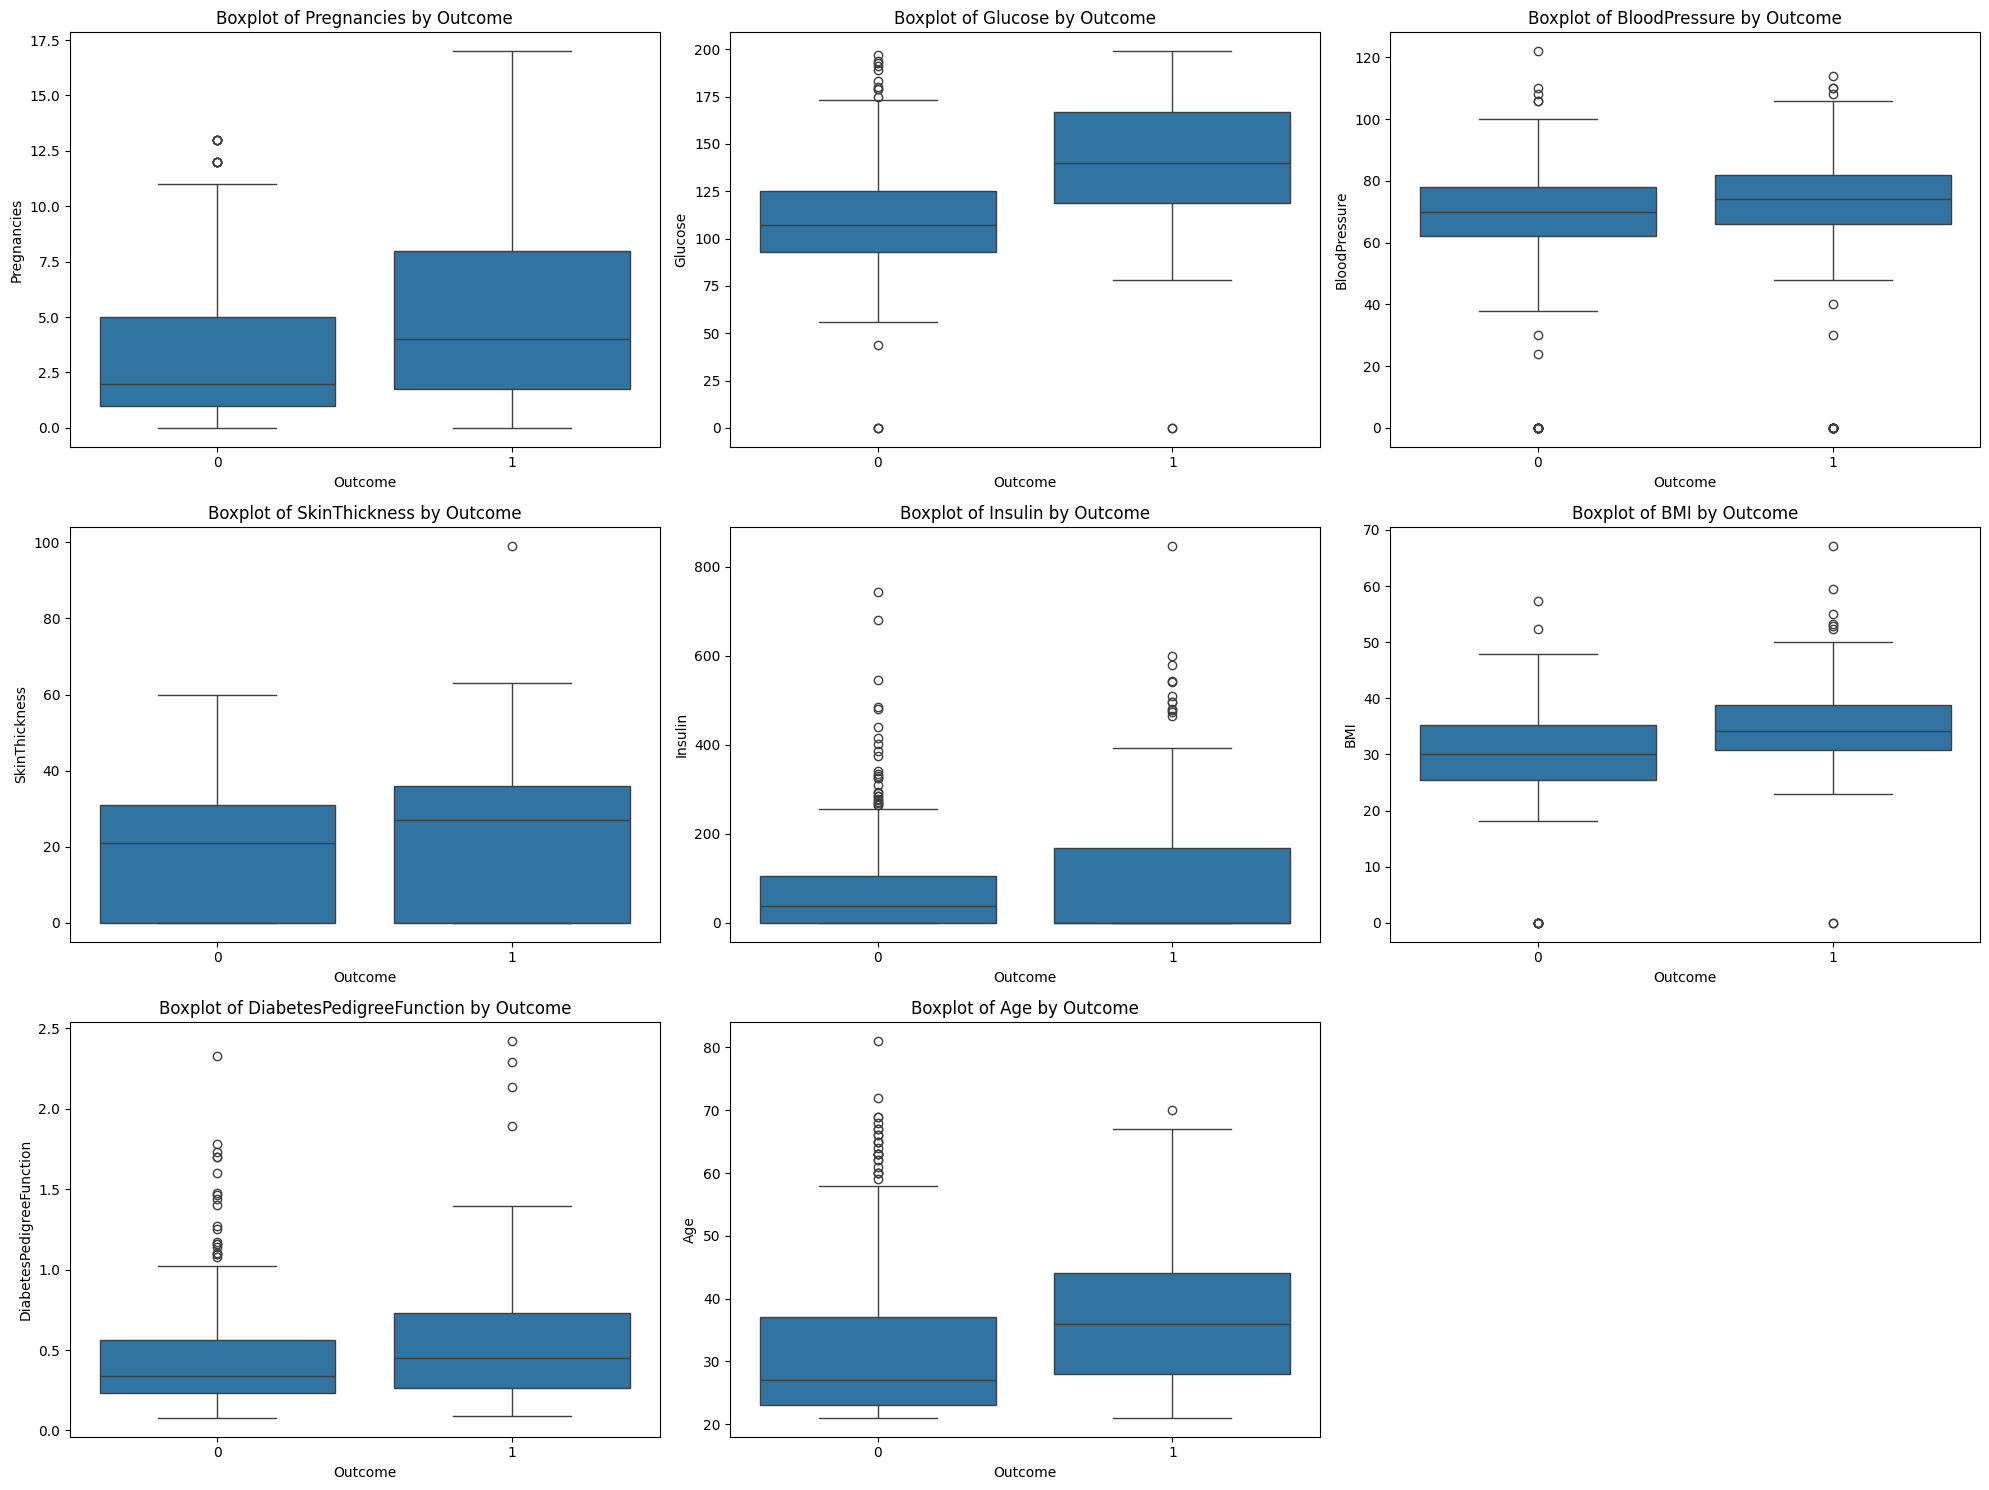

In [19]:
columns_to_plot = df.columns[df.columns != 'Outcome']

plt.figure(figsize=(20, 15))

num_cols = len(columns_to_plot)
num_rows = (num_cols + 2) // 3

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(num_rows, 3, i)
    sns.boxplot(data=df, x='Outcome', y=col)
    plt.title(f'Boxplot of {col} by Outcome')
    plt.xlabel('Outcome')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [20]:
def Check_outliers(data, column):
    
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data.index[(data[column] < lower_bound) | (data[column] > upper_bound)].tolist()

    return outliers



In [21]:
# show outliers

numerical_features = df.select_dtypes(include=np.number)
for column in numerical_features.columns:
    outliers = Check_outliers(df, column)
    if outliers:
        print(f"Outliers in column '{column}': {outliers}")
    else:
        print(f"No outliers found in column '{column}'.")



Outliers in column 'Pregnancies': [88, 159, 298, 455]
Outliers in column 'Glucose': [75, 182, 342, 349, 502]
Outliers in column 'BloodPressure': [7, 15, 18, 43, 49, 60, 78, 81, 84, 106, 125, 172, 177, 193, 222, 261, 266, 269, 300, 332, 336, 347, 357, 362, 426, 430, 435, 453, 468, 484, 494, 522, 533, 535, 549, 589, 597, 601, 604, 619, 643, 691, 697, 703, 706]
Outliers in column 'SkinThickness': [579]
Outliers in column 'Insulin': [8, 13, 54, 111, 139, 153, 186, 220, 228, 231, 247, 248, 258, 286, 296, 360, 370, 375, 392, 409, 415, 480, 486, 519, 574, 584, 612, 645, 655, 695, 707, 710, 715, 753]
Outliers in column 'BMI': [9, 49, 60, 81, 120, 125, 145, 177, 193, 247, 303, 371, 426, 445, 494, 522, 673, 684, 706]
Outliers in column 'DiabetesPedigreeFunction': [4, 12, 39, 45, 58, 100, 147, 187, 218, 228, 243, 245, 259, 292, 308, 330, 370, 371, 383, 395, 445, 534, 593, 606, 618, 621, 622, 659, 661]
Outliers in column 'Age': [123, 363, 453, 459, 489, 537, 666, 674, 684]
No outliers found in col

In [22]:
palette = {'': 'lightcoral', 'diabetic': 'dodgerblue', 0: 'lightcoral', 1: 'dodgerblue'}

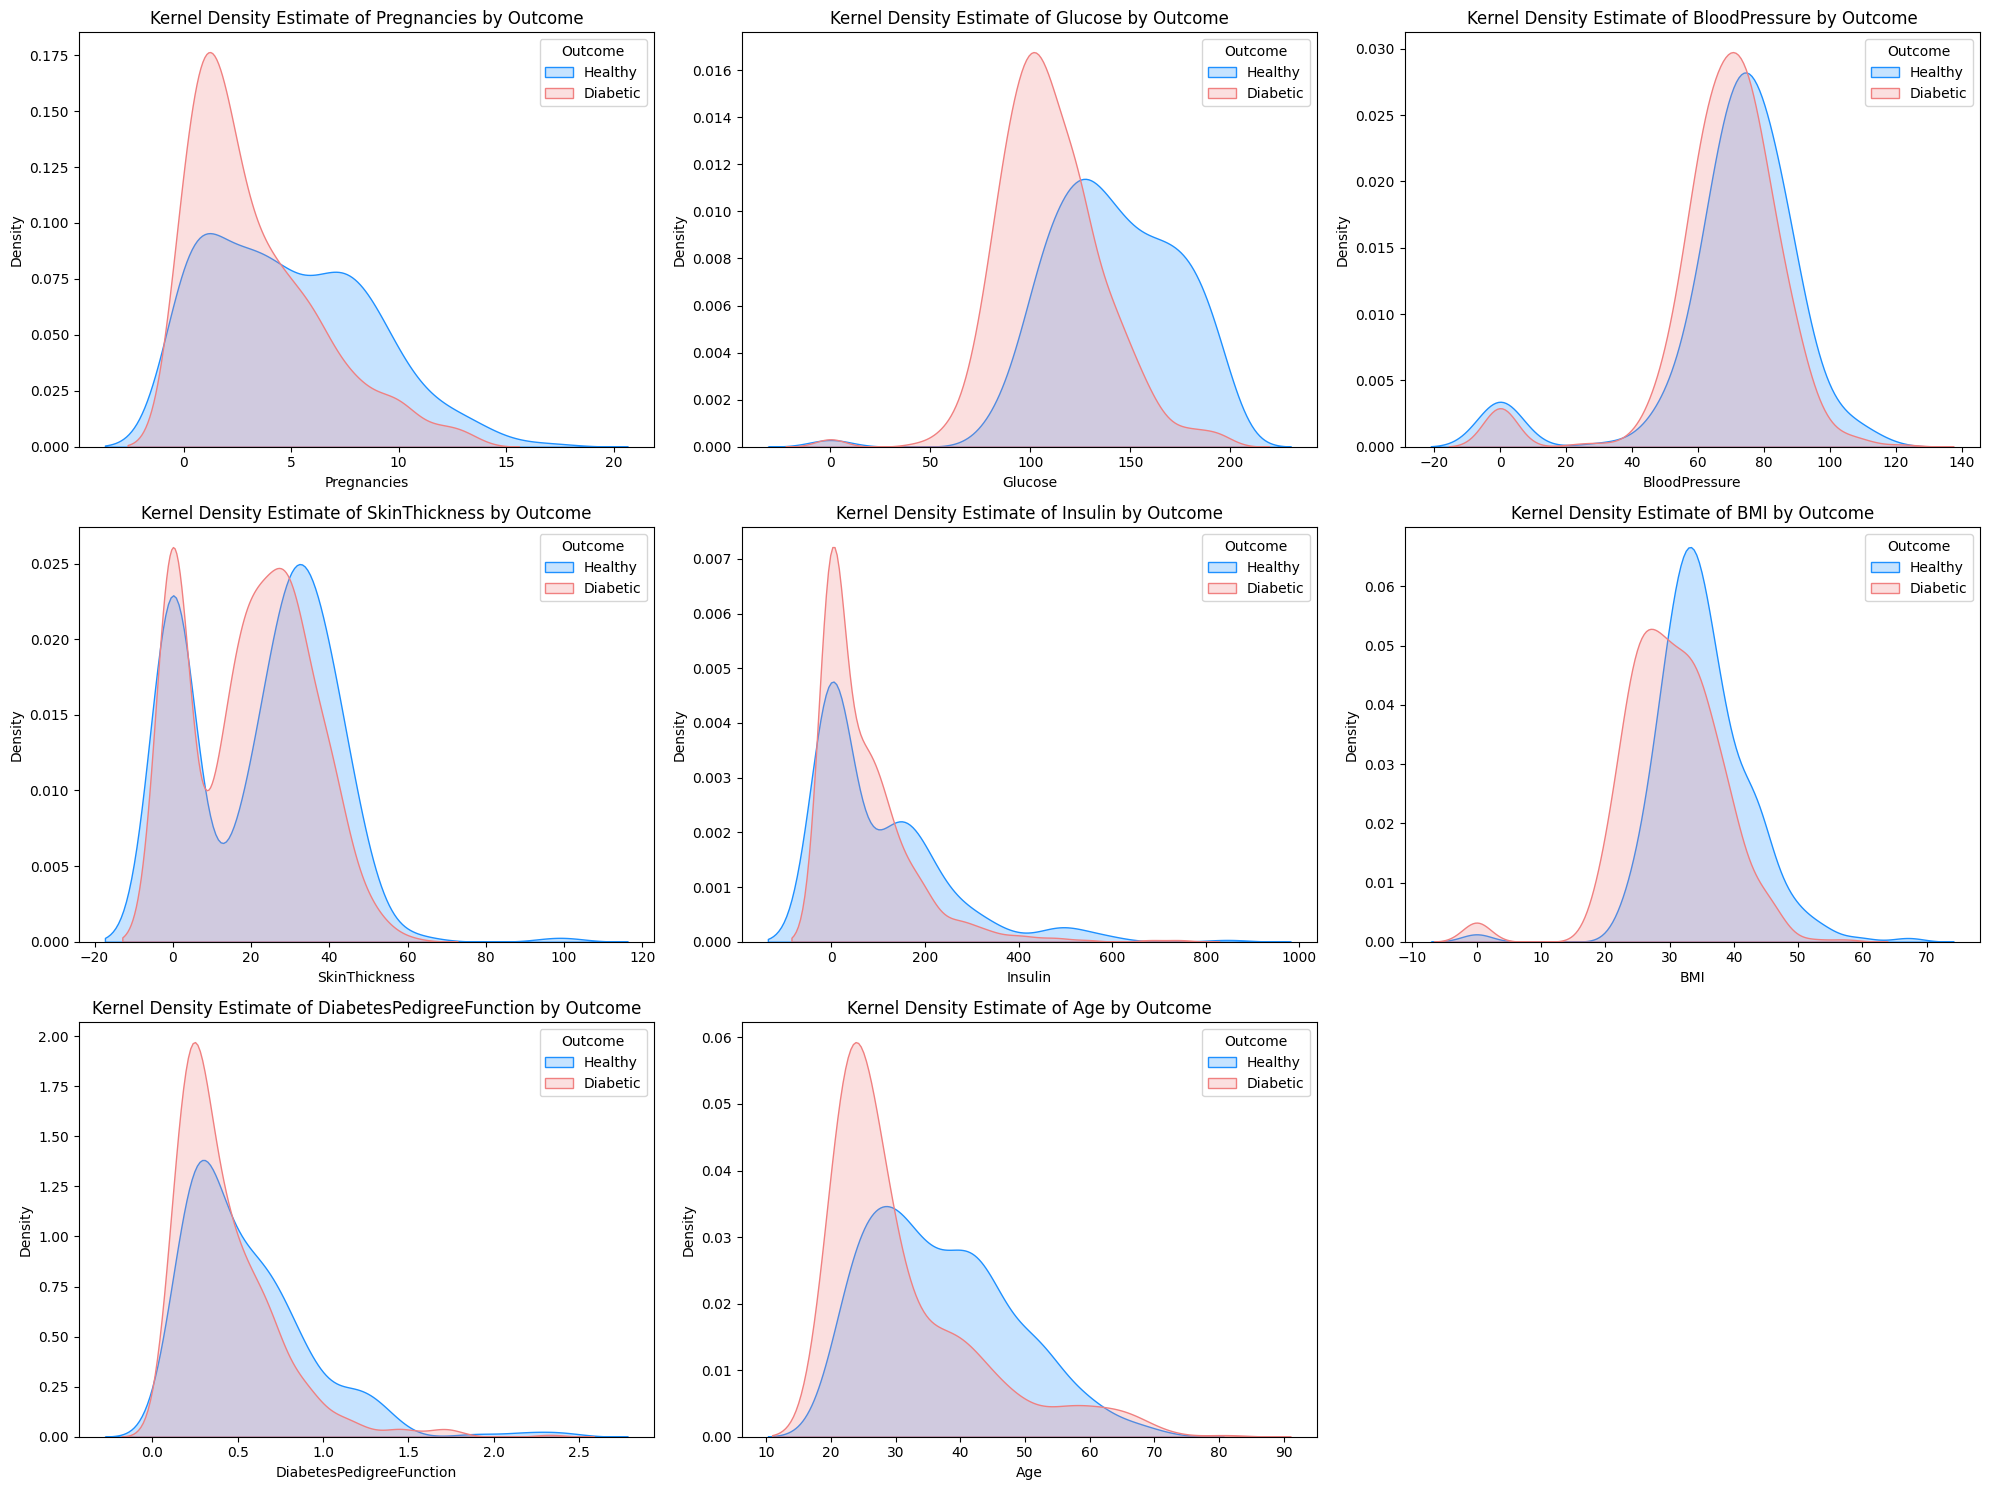

In [23]:
plt.figure(figsize=(20, 15))

variables = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction','Age']

for i, var in enumerate(variables, 1):
    plt.subplot(3, 3, i)
    sns.kdeplot(data=df, x=var, hue='Outcome', fill=True, common_norm=False, palette =palette )
    plt.title(f'Kernel Density Estimate of {var} by Outcome')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend(title='Outcome', labels=['Healthy', 'Diabetic'])

plt.tight_layout()
plt.show()

# **Data Cleaning**

In [24]:
df.drop(columns=['Pregnancies'], inplace=True)

In [97]:
df = shuffle(df)

In [98]:
df.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
67,109,92,0,0,42.7,0.845,54,0
648,136,84,35,130,28.3,0.260,42,1
279,108,62,10,278,25.3,0.881,22,0
5,116,74,0,0,25.6,0.201,30,0
490,83,65,28,66,36.8,0.629,24,0


# **Model Training & Testing**

In [99]:
x = df.drop(columns=['Outcome'])
y = df['Outcome']

In [100]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [101]:
x_train.shape , x_test.shape, y_train.shape, y_test.shape

((537, 7), (231, 7), (537,), (231,))

# **Data Scaling**

In [103]:
RS = RobustScaler()
x_train = RS.fit_transform(x_train)
x_test = RS.transform(x_test)

undersampler = RandomUnderSampler(random_state=42)
x_train, y_train = undersampler.fit_resample(x_train, y_train)


# **Helpers**

In [104]:
def give_me_report(model):
  y_pred_train = model.predict(x_train)
  y_pred_test = model.predict(x_test)
  y_pred = model.predict(x_test)

  print("Train Data:")
  print("Accuracy:", accuracy_score(y_train, y_pred_train))
  print("___________________________________________________")
  print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_pred_train)}")
  print("___________________________________________________")
  print(f"ROC AUC Score: {roc_auc_score(y_train, y_pred_train)}")
  print("___________________________________________________")
  print(classification_report(y_train, y_pred_train))

  print("---------------------------------------------------")
  print("Test Data:")
  print(f"Accuracy Score: {accuracy_score(y_test, y_pred_test)}")
  print("___________________________________________________")
  print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_test)}")
  print("___________________________________________________")
  print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_test)}")
  print("___________________________________________________")
  print(classification_report(y_test, y_pred))
  print(f"Cross Validation Score: {cross_val_score(model, x_train, y_train, cv=5).mean()}")

In [105]:
def plot_confusion_matrix(model):
  y_pred = model.predict(x_test)
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion Matrix for testing data')
  plt.show()

# **Classification Models**

# **Logistic Regression**

In [139]:
log_reg = LogisticRegression()

In [140]:
grid_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'penalty': ['l1', 'l2'],
               'solver': ['liblinear', 'saga']
}

In [141]:
grid_search = GridSearchCV(estimator=log_reg, param_grid=grid_params, cv=5)

In [142]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [143]:
print(grid_search.best_params_)

{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}


In [144]:
best_log_reg = grid_search.best_estimator_

In [145]:
y_pred = best_log_reg.predict(x_test)

In [146]:
give_me_report(best_log_reg)

Train Data:
Accuracy: 0.7172774869109948
___________________________________________________
Confusion Matrix: 
[[139  52]
 [ 56 135]]
___________________________________________________
ROC AUC Score: 0.7172774869109948
___________________________________________________
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       191
           1       0.72      0.71      0.71       191

    accuracy                           0.72       382
   macro avg       0.72      0.72      0.72       382
weighted avg       0.72      0.72      0.72       382

---------------------------------------------------
Test Data:
Accuracy Score: 0.7662337662337663
___________________________________________________
Confusion Matrix: 
[[120  34]
 [ 20  57]]
___________________________________________________
ROC AUC Score: 0.7597402597402597
___________________________________________________
              precision    recall  f1-score   support

           0   

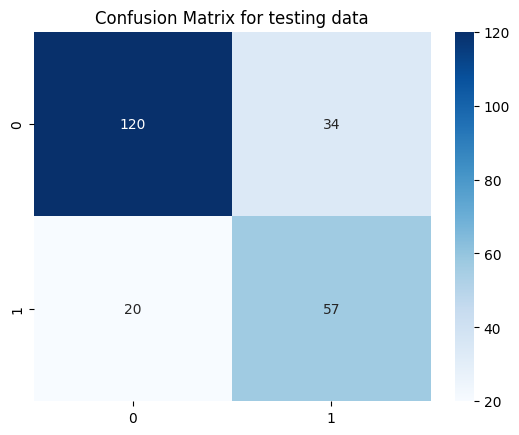

In [148]:
plot_confusion_matrix(best_log_reg)

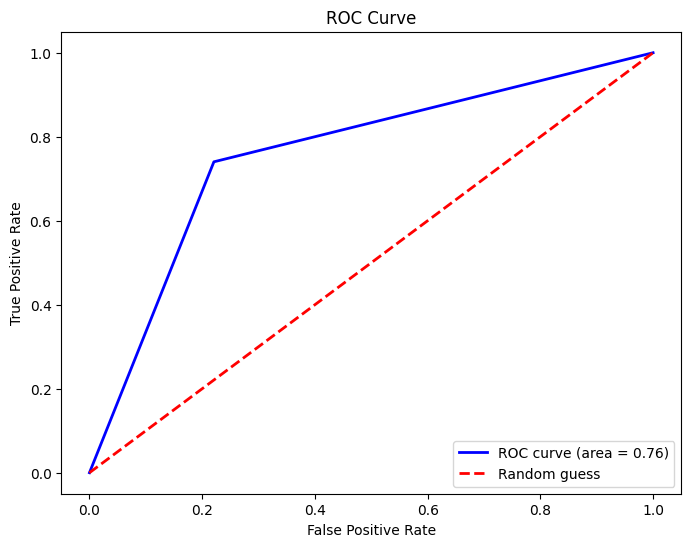

In [149]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



# **Random Forest**

In [118]:
rf = RandomForestClassifier()

In [119]:
param_grid = {'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=rf, param_grid= param_grid, cv=5)

In [120]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [121]:
print(grid_search.best_params_)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


In [122]:
best_rf = grid_search.best_estimator_

In [123]:
y_pred = best_rf.predict(x_test)

In [124]:
give_me_report(best_rf)

Train Data:
Accuracy: 0.9162303664921466
___________________________________________________
Confusion Matrix: 
[[174  17]
 [ 15 176]]
___________________________________________________
ROC AUC Score: 0.9162303664921465
___________________________________________________
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       191
           1       0.91      0.92      0.92       191

    accuracy                           0.92       382
   macro avg       0.92      0.92      0.92       382
weighted avg       0.92      0.92      0.92       382

---------------------------------------------------
Test Data:
Accuracy Score: 0.7965367965367965
___________________________________________________
Confusion Matrix: 
[[121  33]
 [ 14  63]]
___________________________________________________
ROC AUC Score: 0.801948051948052
___________________________________________________
              precision    recall  f1-score   support

           0    

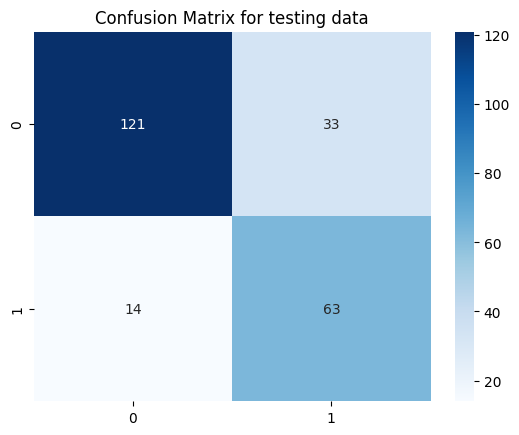

In [125]:
plot_confusion_matrix(best_rf)

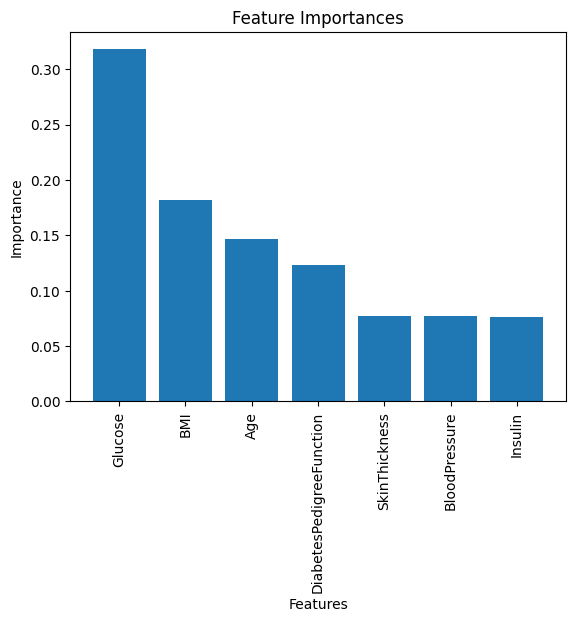

In [127]:
# Access the best estimator's feature importances
importances = best_rf.feature_importances_

# Get the original feature names from the 'x' DataFrame before scaling
feature_names = x.columns

# Create a DataFrame to store feature names and their corresponding importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure()
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()


# **XG Boost**

In [129]:
xgboost = XGBClassifier()

In [130]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [131]:
grid_search = GridSearchCV(estimator=xgboost, param_grid=param_grid, cv=5)

In [132]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]})

In [133]:
print(grid_search.best_params_)

{'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [134]:
best_xgboost = grid_search.best_estimator_

In [135]:
y_pred = best_xgboost.predict(x_test)

In [136]:
give_me_report(best_xgboost)

Train Data:
Accuracy: 0.8036649214659686
___________________________________________________
Confusion Matrix: 
[[145  46]
 [ 29 162]]
___________________________________________________
ROC AUC Score: 0.8036649214659686
___________________________________________________
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       191
           1       0.78      0.85      0.81       191

    accuracy                           0.80       382
   macro avg       0.81      0.80      0.80       382
weighted avg       0.81      0.80      0.80       382

---------------------------------------------------
Test Data:
Accuracy Score: 0.8138528138528138
___________________________________________________
Confusion Matrix: 
[[122  32]
 [ 11  66]]
___________________________________________________
ROC AUC Score: 0.8246753246753247
___________________________________________________
              precision    recall  f1-score   support

           0   

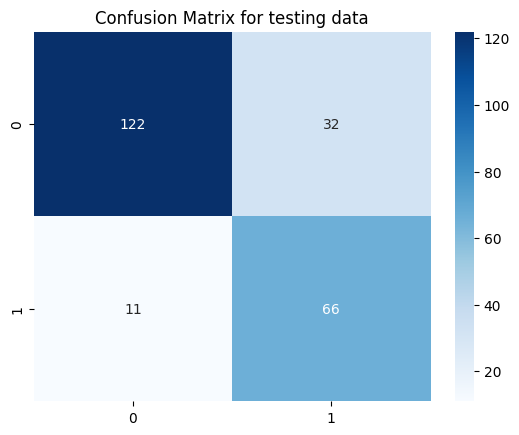

In [138]:
plot_confusion_matrix(best_xgboost)

In [184]:
joblib.dump(best_xgboost, 'best_xgboost.pkl')

['best_xgboost.pkl']

# **k-nearest neighbors (Knn)**

In [152]:
knn = KNeighborsClassifier()

In [153]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

In [154]:
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)

In [155]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [156]:
print(grid_search.best_params_)

{'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


In [157]:
best_knn = grid_search.best_estimator_

In [158]:
y_pred = best_knn.predict(x_test)

In [159]:
give_me_report(best_knn)

Train Data:
Accuracy: 0.7696335078534031
___________________________________________________
Confusion Matrix: 
[[139  52]
 [ 36 155]]
___________________________________________________
ROC AUC Score: 0.7696335078534031
___________________________________________________
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       191
           1       0.75      0.81      0.78       191

    accuracy                           0.77       382
   macro avg       0.77      0.77      0.77       382
weighted avg       0.77      0.77      0.77       382

---------------------------------------------------
Test Data:
Accuracy Score: 0.7532467532467533
___________________________________________________
Confusion Matrix: 
[[114  40]
 [ 17  60]]
___________________________________________________
ROC AUC Score: 0.7597402597402598
___________________________________________________
              precision    recall  f1-score   support

           0   

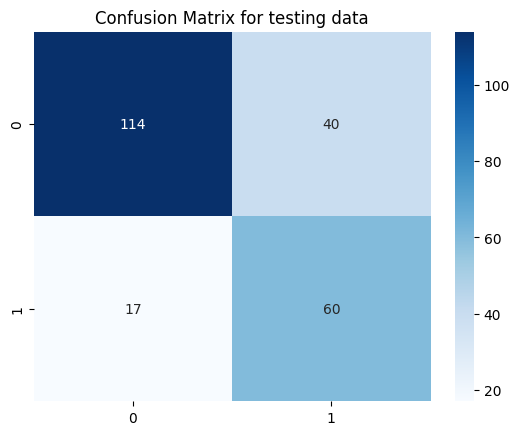

In [160]:
plot_confusion_matrix(best_knn)

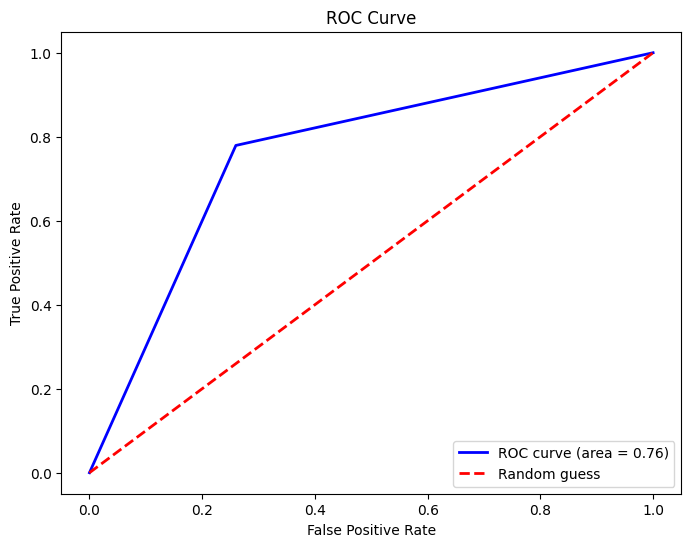

In [163]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# **Support Vector Machine (SVM)**   

In [164]:
svm = SVC()

In [165]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.1, 1]
}

In [166]:
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)

In [167]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']})

In [168]:
print(grid_search.best_params_)

{'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


In [169]:
best_svm = grid_search.best_estimator_

In [170]:
y_pred = best_svm.predict(x_test)

In [171]:
give_me_report(best_svm)

Train Data:
Accuracy: 0.7643979057591623
___________________________________________________
Confusion Matrix: 
[[147  44]
 [ 46 145]]
___________________________________________________
ROC AUC Score: 0.7643979057591623
___________________________________________________
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       191
           1       0.77      0.76      0.76       191

    accuracy                           0.76       382
   macro avg       0.76      0.76      0.76       382
weighted avg       0.76      0.76      0.76       382

---------------------------------------------------
Test Data:
Accuracy Score: 0.7792207792207793
___________________________________________________
Confusion Matrix: 
[[120  34]
 [ 17  60]]
___________________________________________________
ROC AUC Score: 0.7792207792207793
___________________________________________________
              precision    recall  f1-score   support

           0   

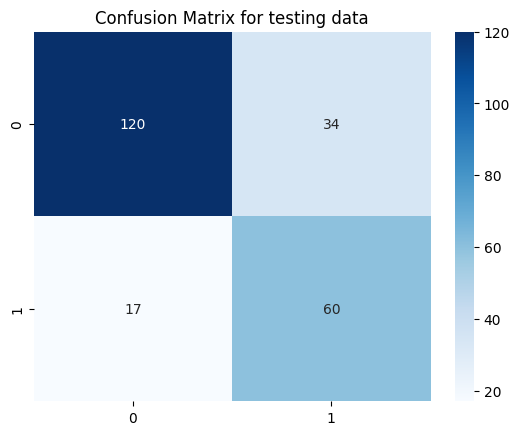

In [172]:
plot_confusion_matrix(best_svm)

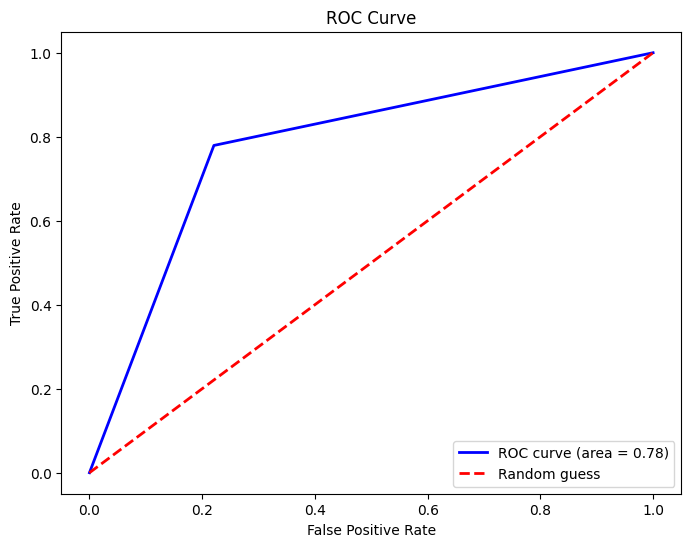

In [173]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# **Decision Tree**

In [174]:
Dt = DecisionTreeClassifier()

In [175]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [176]:
grid_search = GridSearchCV(estimator=Dt, param_grid=param_grid, cv=5)

In [177]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [178]:
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2}


In [179]:
best_Dt = grid_search.best_estimator_

In [180]:
y_pred = best_Dt.predict(x_test)

In [181]:
give_me_report(best_Dt)

Train Data:
Accuracy: 0.7801047120418848
___________________________________________________
Confusion Matrix: 
[[158  33]
 [ 51 140]]
___________________________________________________
ROC AUC Score: 0.7801047120418848
___________________________________________________
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       191
           1       0.81      0.73      0.77       191

    accuracy                           0.78       382
   macro avg       0.78      0.78      0.78       382
weighted avg       0.78      0.78      0.78       382

---------------------------------------------------
Test Data:
Accuracy Score: 0.7142857142857143
___________________________________________________
Confusion Matrix: 
[[110  44]
 [ 22  55]]
___________________________________________________
ROC AUC Score: 0.7142857142857143
___________________________________________________
              precision    recall  f1-score   support

           0   

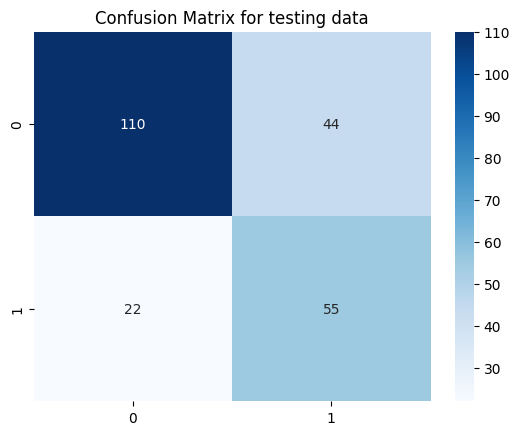

In [182]:
plot_confusion_matrix(best_Dt)

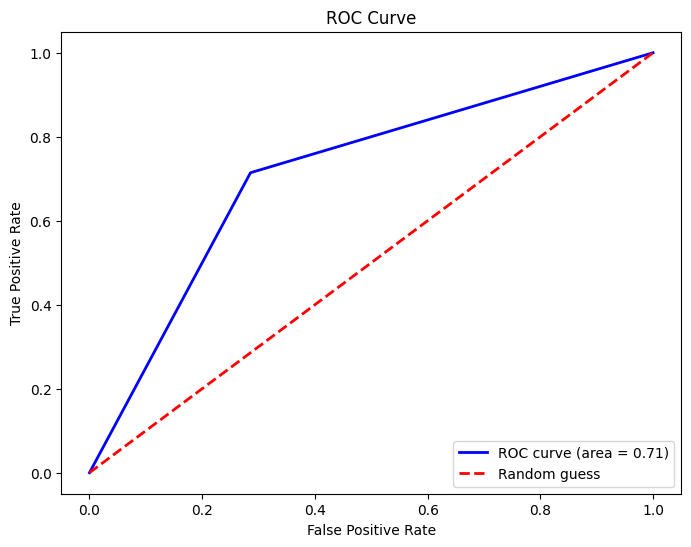

In [183]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# **Conclusion**

## At the conclusion of the project :

* After reviewing the results and evaluating each model based on Precision , recall, and area under the curve, XGBoost had the highest ROC-AUC, making it the best for predicting diabetes outcomes.. Therefore, the model was saved, and a simple web application was created to use the XGBoost model for outcome prediction.   


